In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import sympy as sy
import json

from numpy import cos, sin
from tqdm import tqdm

from scipy.integrate import odeint, quad
from scipy.special import lpmn, lpmv, jv, jnyn_zeros

In [66]:
R_earth = 6400000
R_moon = 1737100
dist_moon = 380000000
R_m = 16 * R_earth
b = 5 * R_earth
g_10 = -29404.8 * 1e-9
g_11 = -1450.9 * 1e-9
h_11 = 4652.5 * 1e-9 
q = 1.6e-19 #Кл
m = 1.67e-27 #Кг
mu_0 = 4*np.pi * 1e-7 # Гн/м
m_x = 4*np.pi*R_earth**3 / mu_0 * g_11
m_y = 4*np.pi*R_earth**3 / mu_0 * h_11
m_z = 4*np.pi*R_earth**3 / mu_0 * g_10

In [77]:
class MagnetField():
    
    def __init__(self, N=100):
        
        self.N = N
        self.a_0, self.a_1, self.x_0, self.x_1 = self.create_const_a(N=N)

    
    def create_start_points_for_particles(self, r_upbound = 1.01*R_earth, r_nums=1,
                                          thetha_nums=2, phi_nums=4, thetha_v=3, phi_v=3, save=False, name='magnetic.json'):
        theta = np.concatenate((np.linspace(0, np.pi/8, num=thetha_nums),
                                np.linspace(np.pi, np.pi+np.pi/8, num=thetha_nums)))
        phi = np.linspace(0, 2*np.pi, num=phi_nums)
        r = np.linspace(1.01*R_earth, r_upbound, num=r_nums)
        theta_v = np.linspace(0, np.pi, num=thetha_v)
        phi_v = np.linspace(0, 2*np.pi, num=phi_v)

        if save:
            data = {'thethas': th,
                   'phies': ph,
                   'radius': rr,
                   'thethas_v': theta_vv,
                   'phies_v': phi_vv
                   }
            with open(name, 'w') as f:
                json.dump(data, f, indent=2, 
                          cls=NumpyEncoder)
            return
        
        return theta, phi, r, theta_v, phi_v
    
    def make_start_points_for_magnetosphere(self, thetha_nums=10, phi_nums=10):
        theta = np.linspace(0, np.pi, num=thetha_nums)
        phi = np.linspace(0, 2*np.pi, num=phi_nums)
        r = np.linspace(R_earth, R_earth, num=1)


        th, ph, rr = np.meshgrid(theta, phi, r)

        th = np.expand_dims(th, axis=-1)
        ph = np.expand_dims(ph, axis=-1)
        rr = np.expand_dims(rr, axis=-1)

        start_points = np.concatenate((rr, th, ph), axis=-1)
        start_points = start_points.reshape(-1, 3)
        return start_points
    
    def create_const_a(self, N=100):
        jn_roots, jnp_roots, yn_roots, ynp_roots = jnyn_zeros(0, 100)
        x_0 = jnp_roots
        jn_roots, jnp_roots, yn_roots, ynp_roots = jnyn_zeros(1, 100)
        x_1 = jnp_roots


        def f0(x):
            S = -b / (b**2 + x**2)**(3/2)
            for n in range(N):
                S += -1/b**2 * (n+1)*(-b / R_m)**(n+1) * (x / R_m)**n * lpmv(0, n, 0)
            return S

        def f1(x):
            S = x / (b**2 + x**2)**(3/2)
            for n in range(1, N + 1):
                S += 1/b**2 * (n+1) / n * (-b / R_m)**(n+1) * (x / R_m)**n * (-lpmv(1, n, 0))
            return S

        def func(x, x_nn, v):
            if v == 0:
                return x*jv(0, x_nn * x / R_m)*f0(x)
            else:
                return x*jv(1, x_nn * x / R_m)*f1(x)


        a_0 = [2 / (R_m**2 * jv(0, x_0[n])**2) * quad(func, 0, R_m, args=(x_0[n], 0))[0] for n in tqdm(range(100), desc="Подсчет a_0")]
        a_1 = [2 / (R_m**2 * jv(1, x_1[n])**2 * (1 - (1 / x_1[n])**2) ) * quad(func, 0, R_m, args=(x_1[n], 1))[0] for n in tqdm(range(100), desc="Подсчет a_1")]
        return a_0, a_1, x_0, x_1
    
    def legs(self, theta):
    
        legs_0n = [cos(theta), 1/2*(3*cos(theta)**2-1),
                   1/2*(5*cos(theta)**3-3*cos(theta)), 1/8*(35*cos(theta)**4-30*cos(theta)**2+3),
                  1/8*(63*cos(theta)**5-70*cos(theta)**3+15*cos(theta)), 1/16*(231*cos(theta)**6-315*cos(theta)**4+105*cos(theta)**2-5),
                  1/16*(429*cos(theta)**7-693*cos(theta)**5+315*cos(theta)**3-35*cos(theta)), 1/128*(6435*cos(theta)**8 - 12012*cos(theta)**6 + 6930*cos(theta)**4 - 1260*cos(theta)**2 + 35),
                  1/128*(12155*cos(theta)**9 - 25740*cos(theta)**7 + 18018*cos(theta)**5 - 4620*cos(theta)**3 + 315*cos(theta)),
                  1/256*(46189*cos(theta)**10 - 109395*cos(theta)**8 + 90090*cos(theta)**6 - 30030*cos(theta)**4 + 3465*cos(theta)**2 - 63)]

        legs_1n = [np.abs(sin(theta)), 3*cos(theta)*np.abs(sin(theta)),
                   3/2*np.abs(sin(theta))*(5*cos(theta)**2-1), 5/2*np.abs(sin(theta))*(7*cos(theta)**3-3*cos(theta)),
                  15/8*np.abs(sin(theta))*(21*cos(theta)**4-14*cos(theta)**2+1), 21/8*np.abs(sin(theta))*(33*cos(theta)**5-30*cos(theta)**3+5*cos(theta)),
                  7/16*np.abs(sin(theta))*(429*cos(theta)**6-495*cos(theta)**4+135*cos(theta)**2-5), 9/16*np.abs(sin(theta))*(715*cos(theta)**7-1001*cos(theta)**5+385*cos(theta)**3-35*cos(theta)),
                  45/128*np.abs(sin(theta))*(2431*cos(theta)**8 - 4004*cos(theta)**6 + 2002*cos(theta)**4 - 308*cos(theta)**2 + 7),
                  55/128*np.abs(sin(theta))*(4199*cos(theta)**9 - 7956*cos(theta)**7 + 4914*cos(theta)**5 - 1092*cos(theta)**3 + 63*cos(theta))]

        divlegs_0n = [-sin(theta), -3*sin(theta)*cos(theta),
                      -3/2*sin(theta)*(5*cos(theta)**2-1), -5/2*sin(theta)*cos(theta)*(7*cos(theta)**2-3),
                     -15/8*sin(theta)*(21*cos(theta)**4 - 14*cos(theta)**2 + 1), -21/8*sin(theta)*cos(theta)*(33*cos(theta)**4 - 30*cos(theta)**2 + 5),
                     -7/16*sin(theta)*(429*cos(theta)**6 - 495*cos(theta)**4 + 135*cos(theta)**2 - 5), -9/16*sin(theta)*cos(theta)*(715*cos(theta)**6 - 1001*cos(theta)**4 + 385*cos(theta)**2 - 35),
                     -45/128*sin(theta)*(2431*cos(theta)**8-4004*cos(theta)**6 + 2002*cos(theta)**4 - 308*cos(theta)**2 + 7),
                     -55/128*sin(theta)*cos(theta)*(4199*cos(theta)**8 - 7956*cos(theta)**6 + 4914*cos(theta)**4 - 1092*cos(theta)**2 + 63)]

        divlegs_1n = [cos(theta)*np.sign(sin(theta)), -3*np.sign(sin(theta))*(1-2*cos(theta)**2),
                      -3/2*np.sign(sin(theta))*cos(theta)*(11-15*cos(theta)**2), 5/2*np.sign(sin(theta))*(28*cos(theta)**4 - 27*cos(theta)**2 + 3),
                     15/8*np.sign(sin(theta))*cos(theta)*(105*cos(theta)**4 - 126*cos(theta)**2 + 29), 21/8*np.sign(sin(theta))*(198*cos(theta)**6 - 285*cos(theta)**4 + 100*cos(theta)**2 - 5),
                     7/16*np.sign(sin(theta))*cos(theta)*(3003*cos(theta)**6 - 5049*cos(theta)**4 + 2385*cos(theta)**2 - 275),
                     9/16*np.sign(sin(theta))*(5720*cos(theta)**8 - 11011*cos(theta)**6 + 6545*cos(theta)**4 - 1225*cos(theta)**2 + 35),
                     45/128*np.sign(sin(theta))*cos(theta)*(21879*cos(theta)**8 - 47476*cos(theta)**6+34034*cos(theta)**4-8932*cos(theta)**2+623),
                     55/128*np.sign(sin(theta))*(41990*cos(theta)**10-101439*cos(theta)**8+85176*cos(theta)**6-28938*cos(theta)**4+3402*cos(theta)**2 - 63)]

        legs_1n_div_sin = [np.sign(sin(theta)), 3*cos(theta)*np.sign(sin(theta)),
                           3/2*np.sign(sin(theta))*(5*cos(theta)**2-1), 5/2*np.sign(sin(theta))*(7*cos(theta)**3-3*cos(theta)),
                          15/8*np.sign(sin(theta))*(21*cos(theta)**4-14*cos(theta)**2+1), 21/8*np.sign(sin(theta))*(33*cos(theta)**5-30*cos(theta)**3+5*cos(theta)),
                          7/16*np.sign(sin(theta))*(429*cos(theta)**6-495*cos(theta)**4+135*cos(theta)**2-5), 9/16*np.sign(sin(theta))*(715*cos(theta)**7-1001*cos(theta)**5+385*cos(theta)**3-35*cos(theta)),
                          45/128*np.sign(sin(theta))*(2431*cos(theta)**8 - 4004*cos(theta)**6 + 2002*cos(theta)**4 - 308*cos(theta)**2 + 7),
                          55/128*np.sign(sin(theta))*(4199*cos(theta)**9 - 7956*cos(theta)**7 + 4914*cos(theta)**5 - 1092*cos(theta)**3 + 63*cos(theta))]


        return legs_0n, legs_1n, divlegs_0n, divlegs_1n, legs_1n_div_sin
    
    def sphere_to_decart(self, point, B):
        r, theta, phi = point
        C = np.array([[sin(theta)*cos(phi), sin(theta)*sin(phi), cos(theta)],
                      [cos(theta)*cos(phi), cos(theta)*sin(phi), -sin(theta)],
                      [-sin(phi), cos(phi), 0]])
        B_xyz = B @ C
        point_xyz = np.array([r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta)])
        return B_xyz, point_xyz

    def decart_to_sphere(self, x, y, z, eps=1e-8):
        r = np.sqrt(x**2 + y**2 + z**2)
        theta = np.arccos(z /  r)
        phi = np.arctan(y / x) if x > 0 else np.arctan(y / x) + np.pi
        return np.array([r, theta, phi])
    
    def spher_to_cyl(self, point):
        r, theta, phi = point

        rho = r*sin(theta)
        phi = phi
        z = r*cos(theta)

        return rho, phi, z
    
    def conf_B_tail(self, point, lambd, N=10):
        rho, phi, z = self.spher_to_cyl(point)

        B_rho = 0
        B_phi = 0
        B_z = 0

        for n in range(N):

            B_rho += mu_0/(4*np.pi)*(self.x_0[n] / R_m * m_x * self.a_0[n]*jv(1, self.x_0[n] * rho / R_m)*np.exp(-self.x_0[n]*z/R_m)
                                        + 0.5*self.x_1[n]/R_m*self.a_1[n]*m_z*cos(phi)*(jv(2, self.x_1[n] * rho / R_m) - jv(0, self.x_1[n] * rho / R_m))*np.exp(-self.x_1[n]*z/R_m)
                                        + 0.5*self.x_1[n]/R_m*self.a_1[n]*m_y*sin(phi)*(jv(2, self.x_1[n] * rho / R_m) - jv(0, self.x_1[n] * rho / R_m))*np.exp(-self.x_1[n]*z/R_m)
                                    )

            B_phi += mu_0/(4*np.pi)*(1/rho*self.a_1[n]*m_z*sin(phi)*jv(1, self.x_1[n] * rho / R_m)*np.exp(-self.x_1[n]*z/R_m)
                                         - 1/rho*self.a_1[n]*m_y*cos(phi)*jv(1, self.x_1[n] * rho / R_m)*np.exp(-self.x_1[n]*z/R_m)
                                    )

            B_z += mu_0/(4*np.pi)*(self.x_0[n] / R_m * m_x * self.a_0[n]*jv(0, self.x_0[n] * rho / R_m)*np.exp(-self.x_0[n]*z/R_m)
                                       + self.x_1[n]/R_m*self.a_1[n]*m_z*cos(phi)*jv(1, self.x_1[n] * rho / R_m)*np.exp(-self.x_1[n]*z/R_m)
                                       + self.x_1[n]/R_m*self.a_1[n]*m_y*sin(phi)*jv(1, self.x_1[n] * rho / R_m)*np.exp(-self.x_1[n]*z/R_m)
                                  )

            B_rho += lambd*mu_0/(4*np.pi)*(self.x_0[n] / R_m * m_x * self.a_0[n]*jv(1, self.x_0[n] * rho / R_m)*np.exp(-lambd*self.x_0[n]*z/R_m)
                                        + 0.5*self.x_1[n]/R_m*self.a_1[n]*m_z*cos(phi)*(jv(2, self.x_1[n] * rho / R_m) - jv(0, self.x_1[n] * rho / R_m))*np.exp(-lambd*self.x_1[n]*z/R_m)
                                        + 0.5*self.x_1[n]/R_m*self.a_1[n]*m_y*sin(phi)*(jv(2, self.x_1[n] * rho / R_m) - jv(0, self.x_1[n] * rho / R_m))*np.exp(-lambd*self.x_1[n]*z/R_m)
                                    )

            B_phi += lambd*mu_0/(4*np.pi)*(1/rho*self.a_1[n]*m_z*sin(phi)*jv(1, self.x_1[n] * rho / R_m)*np.exp(-lambd*self.x_1[n]*z/R_m)
                                         - 1/rho*self.a_1[n]*m_y*cos(phi)*jv(1, self.x_1[n] * rho / R_m)*np.exp(-lambd*self.x_1[n]*z/R_m)
                                    )

            B_z += mu_0/(4*np.pi)*(self.x_0[n] / R_m * m_x * self.a_0[n]*jv(0, self.x_0[n] * rho / R_m)*np.exp(-lambd*self.x_0[n]*z/R_m)
                                       + self.x_1[n]/R_m*self.a_1[n]*m_z*cos(phi)*jv(1, self.x_1[n] * rho / R_m)*np.exp(-lambd*self.x_1[n]*z/R_m)
                                       + self.x_1[n]/R_m*self.a_1[n]*m_y*sin(phi)*jv(1, self.x_1[n] * rho / R_m)*np.exp(-lambd*self.x_1[n]*z/R_m)
                                  )



        return np.array([B_rho, B_phi, B_z])

    def cyl_to_dec(self, point, B):
        rho, phi, z = self.spher_to_cyl(point)
        C = np.array([[cos(phi), -sin(phi), 0],
                      [sin(phi), cos(phi), 0],
                      [0, 0, 1]])
        B_xyz = C @ B
        point_xyz = np.array([rho*cos(phi), rho*sin(phi), z])
        return B_xyz, point_xyz
    
    def conf_B_sphere_cfa(self, point, B_imf_xyz):
        r, theta, phi = point
        legs_0n, legs_1n, divlegs_0n, divlegs_1n, legs_1n_div_sin = self.legs(theta)
        B_cfa_r = - (R_m / r)**3 * (B_imf_xyz[2]*legs_0n[0] + B_imf_xyz[0]*cos(phi)*legs_1n[0] + B_imf_xyz[1]*sin(phi)*legs_1n[0])
        B_cfa_theta = 0.5 * (R_m / r)**3 * (B_imf_xyz[2]*divlegs_0n[0] + B_imf_xyz[0]*cos(phi)*divlegs_1n[0] + B_imf_xyz[1]*sin(phi)*divlegs_1n[0])
        B_cfa_phi = 0.5 * (R_m / r)**3 * (-B_imf_xyz[0]*sin(phi)*legs_1n_div_sin[0] + B_imf_xyz[1]*cos(phi)*legs_1n_div_sin[0])
        return np.array([B_cfa_r, B_cfa_theta, B_cfa_phi])

    def conf_B_cyl_cfa(self, point, B_imf_xyz):
        rho, phi, z = self.spher_to_cyl(point)
        B_cfa_rho = - (R_m / rho)**2 * (B_imf_xyz[0]*cos(phi) + B_imf_xyz[1]*sin(phi))
        B_cfa_phi = (R_m / rho)**2 * (-B_imf_xyz[0]*sin(phi) + B_imf_xyz[1]*cos(phi))
        B_cfa_z = 0
        return np.array([B_cfa_rho, B_cfa_phi, B_cfa_z])
    
    def conf_B_dip_xyz_M(self, point):
        r_M, theta_M, phi_M = point
        x_M, y_M, z_M = r_M*sin(theta_M)*cos(phi_M), r_M*sin(theta_M)*sin(phi_M), r_M*cos(theta_M)

        r = np.sqrt((z_M + b)**2 + y_M**2 + x_M**2)

        B_x = -(R_earth / r)**3 * g_10 + 3*R_earth**3 / r**5 * x_M * (-g_11*(z_M+b) + y_M*h_11 + x_M*g_10)
        B_y = -(R_earth / r)**3 * h_11 + 3*R_earth**3 / r**5 * y_M * (-g_11*(z_M+b) + y_M*h_11 + x_M*g_10)
        B_z = (R_earth / r)**3 * g_11 + 3*R_earth**3 / r**5 * (z_M+b) * (-g_11*(z_M+b) + y_M*h_11 + x_M*g_10)
        return np.array([B_x, B_y, B_z]), np.array([x_M, y_M, z_M])

    def conf_B_cfi_N(self, point, N=1):
        r, theta, phi = point # r_m, theta_m, phi_m
        B_r = 0
        B_theta = 0
        B_phi = 0

        legs_0n, legs_1n, divlegs_0n, divlegs_1n, legs_1n_div_sin = self.legs(theta)


        for n in range(1, N + 1):
            leg_0n = legs_0n[n-1]
            leg_1n = legs_1n[n-1]

            divleg_0n = divlegs_0n[n-1]
            divleg_1n = divlegs_1n[n-1]

            leg_1n_div_sin = legs_1n_div_sin[n-1]

            B_r += mu_0 / (4*np.pi * b**3) * (n+1) * (-b / R_m)**(n+2) * (r / R_m)**(n-1) * (
                   -n*m_x*leg_0n + (m_z*cos(phi) + m_y*sin(phi)) * leg_1n
                )

            B_theta +=  mu_0 / (4*np.pi * b**3) * (n+1) / n * (-b / R_m)**(n+2) * (r / R_m)**(n-1) * (
                        -n*m_x*divleg_0n + (m_z*cos(phi) + m_y*sin(phi)) * divleg_1n
            )

            B_phi += mu_0 / (4*np.pi * b**3) * (n+1) / n * (-b / R_m)**(n+2) * (r / R_m)**(n-1) * (
                        (-m_z*sin(phi) + m_y*cos(phi)) * leg_1n_div_sin
            )

        return np.array([B_r, B_theta, B_phi])
    
    def conf_B(self, point, C_i, C_a, lambd):
        point = self.decart_to_sphere(*point) # x_m, y_m, z_m -> r_m, theta_m, phi_m
        B_dip_xyz, point_dip_xyz = self.conf_B_dip_xyz_M(point)

        B_cfi = self.conf_B_cfi_N(point, N=10)
        B_cfi_xyz, point_cfi_xyz = self.sphere_to_decart(point, B_cfi)

        B_cfa = self.conf_B_sphere_cfa(point, B_imf_xyz)
        B_cfa_xyz, point_cfa_xyz = self.sphere_to_decart(point, B_cfa)

        B_tail = self.conf_B_tail(point, lambd, N=self.N)
        B_tail_xyz, point_tail_xyz = self.cyl_to_dec(point, B_tail)

        B_cfa_cyl = self.conf_B_cyl_cfa(point, B_imf_xyz)
        B_cfa_cyl_xyz, point_cfa_cyl_xyz = self.cyl_to_dec(point, B_cfa_cyl)

        point_xyz = point_dip_xyz

        #проверка в цилиндре мы или в полусфере
        if point_xyz[-1] < 0 and point[0] < R_m:
            B_xyz = B_dip_xyz + (1 - C_i) * B_cfi_xyz + C_a*B_imf_xyz
        elif point_xyz[-1] > 0 and point[0]*sin(point[1]) < R_m:
            B_xyz = B_tail_xyz + C_a*B_imf_xyz
        elif point_xyz[-1] < 0 and point[0] >= R_m:
            B_xyz = B_imf_xyz + (1 - C_a) * B_cfa_xyz
        else:
            B_xyz = B_imf_xyz + (1 - C_a) * B_cfa_cyl_xyz
        return B_xyz

    def make_Earth(self, data=None):
        def ms(x, y, z, radius, resolution=20):
            """Return the coordinates for plotting a sphere centered at (x,y,z)"""
            u, v = np.mgrid[0:2*np.pi:resolution*2j, 0:np.pi:resolution*1j]
            X = radius * np.cos(u)*np.sin(v) + x
            Y = radius * np.sin(u)*np.sin(v) + y
            Z = radius * np.cos(v) + z
            return (X, Y, Z)

        data = [] if data is None else data
        (x_pns_surface, y_pns_surface, z_pns_suraface) = ms(-b, 0, 0, R_earth)
        data.append(go.Surface(x=x_pns_surface, y=y_pns_surface, z=z_pns_suraface, opacity=0.5))
        return data

    def make_start_points(self, thetha_nums=10, phi_nums=10):
        theta = np.linspace(0, np.pi, num=thetha_nums)
        phi = np.linspace(0, 2*np.pi, num=phi_nums)
        r = np.linspace(R_earth, R_earth, num=1)


        th, ph, rr = np.meshgrid(theta, phi, r)

        th = np.expand_dims(th, axis=-1)
        ph = np.expand_dims(ph, axis=-1)
        rr = np.expand_dims(rr, axis=-1)

        start_points = np.concatenate((rr, th, ph), axis=-1)
        start_points = start_points.reshape(-1, 3)
        return start_points


    def make_magnetosphere(self, maxiter, C_i, C_a, lambd, B_imf_xyz, thetha_nums=10, phi_nums=10, data=None):
        data = [] if data is None else data
        for point in tqdm(self.make_start_points_for_magnetosphere(thetha_nums, phi_nums)):
            r = point[0]
            step = -1 if point[1] < np.pi/2 else 1
            X = []
            Y = []
            Z = []
            i = 0

            r, theta, phi = point

            x, y, z = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta)
            x_M, y_M, z_M = z, y, -(x+b)
            point_xyz = np.array([x_M, y_M, z_M])


            while r >= R_earth and r <= 2*R_m and i < maxiter:

                X += [point_xyz[0]]
                Y += [point_xyz[1]]
                Z += [point_xyz[2]]

                B_xyz = self.conf_B(point_xyz, C_i, C_a, lambd)

                #Это условие нужно, чтобы через граничную область линии не перескакивали, тк они могут улететь из-за этого
                if (R_m - b) * 1/8 <= r <= (R_m - b) * 15/8:
                    point_xyz = point_xyz + step*B_xyz / np.sqrt(np.sum(B_xyz**2)) * 1e5
                else:
                    point_xyz = point_xyz + step*B_xyz / np.sqrt(np.sum(B_xyz**2)) * 1e6

                x, y, z = point_xyz

                r = np.sqrt(x**2 + y**2 + (z + b)**2)
                i += 1

            X += [point_xyz[0]]
            Y += [point_xyz[1]]
            Z += [point_xyz[2]]

            X = np.array(X)
            Y = np.array(Y)
            Z = np.array(Z)

            data.append(go.Scatter3d(x=Z, y=Y, z=X,
                                     marker=dict(
                                                 size=0.1,
                                                 color='blue',      # set color to an array/list of desired values
                                                 colorscale=None,   # choose a colorscale
                                                 opacity=0.8
                                                ),
                                     showlegend=False
                                    )
                       )
        return data
    
    def make_iterator(self, len_thetha, len_phi, len_r, len_theta_v, len_phi_v,
                      start_i, start_j, start_k, start_l, start_m):
        return ([i,j,k,l,m] for i in range(start_i, len_thetha)
                            for j in range(start_j, len_phi)
                            for k in range(start_k, len_r)
                            for l in range(start_l, len_theta_v)
                            for m in range(start_m, len_phi_v))
    
    def download(self):
        try:
            with open("progress.txt") as f:
                i, j, k, l, m, count = f.read().strip().split()
                return int(i), int(j), int(k), int(l), int(m), float(count)
        except FileNotFoundError:
            return [0, 0, 0, 0, 0, 0]
    
    def count_particles(self, t, C_i, C_a, lambd, B_imf_xyz, m_particles,
                        q_particles, v=1.38e6, r_upbound = 1.01*R_earth,
                        r_nums=1, thetha_nums=2, phi_nums=4, thetha_v=3, phi_v=3, plotdata=False, data=None, download=False):
        
        def pend(y, t, q, m, C_i, C_a, lambd):
            y1, y2, y3, y4, y5, y6 = y
            point = np.array([y1, y3, y5])
            B_xyz = self.conf_B(point, C_i, C_a, lambd)
            if np.sqrt(point[0]**2 + point[1]**2 + (point[2] + b)**2) <= R_earth or np.sqrt(point[0]**2 + point[1]**2 + (point[2] + b - dist_moon)**2) <= R_moon:
                f = [0, 0, 0, 0, 0, 0]
            else:
                f = [y2, q/m*(y4*B_xyz[2] - y6*B_xyz[1]), y4, q/m*(y6*B_xyz[0] - y2*B_xyz[2]), y6, q/m*(y2*B_xyz[1] - y4*B_xyz[0])]
            return f
        
        data = [] if data is None else data
        thetas, phies, rs, theta_vs, phi_vs = self.create_start_points_for_particles(r_upbound = r_upbound,
                                                              r_nums=r_nums, thetha_nums=thetha_nums,
                                                              phi_nums=phi_nums, thetha_v=thetha_v, phi_v=phi_v)
        start_i, start_j, start_k, start_l, start_m, count = self.download() if download else [0, 0, 0, 0, 0, 0]
        
        total = (len(thetas)*len(phies)*len(rs)*len(theta_vs)*len(phi_vs)
                 - (start_i + 1)*(start_j + 1)*(start_k + 1)*(start_l + 1)*(start_m) + 1)

        for i, j ,k, l, m in tqdm(self.make_iterator(
                                                     len(thetas),
                                                     len(phies),
                                                     len(rs),
                                                     len(theta_vs),
                                                     len(phi_vs),
                                                     start_i,
                                                     start_j,
                                                     start_k,
                                                     start_l,
                                                     start_m
                                                    ),
                                  total=total
                                 ):
            try:
                theta, phi, r, theta_v, phi_v = thetas[i], phies[j], rs[k], theta_vs[l], phi_vs[m] 
#                 theta, phi, r, theta_v, phi_v = np.pi/2, np.pi, dist_moon, 0, 0
                x, y, z = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta)
                x_M, y_M, z_M = z, y, -(x+b)

                v_x, v_y, v_z = v*sin(theta_v)*cos(phi_v), v*sin(theta_v)*sin(phi_v), v*cos(theta_v)
                v_xM, v_yM, v_zM = v_z, v_y, -v_x

                # x, v_x, y, v_y, z, v_z
                y0 = [x_M, v_xM,
                      y_M, v_yM,
                      z_M, v_zM]

                sol = odeint(pend, y0, t, args=(q_particles, m_particles, C_i, C_a, lambd))

                X = sol[:, 0]
                Y = sol[:, 2]
                Z = sol[:, 4]
                if plotdata:
                    data.append(go.Scatter3d(x=Z, y=Y, z=X,
                                             marker=dict(
                                                         size=0.1,
                                                         color='orange',                # set color to an array/list of desired values
                                                         colorscale=None,   # choose a colorscale
                                                         opacity=0.8
                                                        )
                                            )
                               )
                if np.sqrt(X[-1]**2 + Y[-1]**2 + (Z[-1] + b - dist_moon)**2) <= R_moon:
                    count += 1 / (len(thetas)*len(phies)*len(rs)*len(theta_vs)*len(phi_vs))
            except KeyboardInterrupt:
                # this is really rude to do, by the by....
                print("Сохранение и выход")
                with open("progress.txt", "w") as f:
                    f.write(' '.join(map(str, [i, j, k, l, m, count])))
                break
        return data, count
    
    def plot_image(self, data):
        fig = go.Figure(data=data)
        fig.update_layout(coloraxis_showscale=False)
        fig.update_layout(
            autosize=False,
            width=1200,
            height=800)
        fig.for_each_annotation(lambda a: a.update(text=""))
        fig.show()

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


In [74]:
magn = MagnetField(N=10)

Подсчет a_1: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 33.10it/s]


In [22]:
maxiter = 10000
C_i = 0.1
C_a = 0.9
lambd = 0.15
B_imf_xyz = np.array([5*1e-9, 0, 0])
data = magn.make_Earth()
data = magn.make_magnetosphere(maxiter, C_i, C_a, lambd, B_imf_xyz, thetha_nums=1, phi_nums=1, data=data)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  7.00s/it]


In [75]:
maxiter = 10000
B_imf_xyz = np.array([0, 0, 5e-9])
C_i = 0.1
C_a = 0.9
lambd = 0.15
m_particles = 32*m
q_particles = q
t = np.linspace(0, 1000, 10000)
data, count = magn.count_particles(t, C_i, C_a, lambd, B_imf_xyz, m_particles,
                            q_particles, v=1.38e6, r_upbound = 1.1*R_earth,
                            r_nums=5, thetha_nums=10, phi_nums=10, thetha_v=10, phi_v=10,
                            plotdata=False, data=None, download=False)

  0%|                                                                                       | 0/100001 [00:00<?, ?it/s]<ipython-input-73-69eeb42765bd>:157: RuntimeWarning: divide by zero encountered in double_scalars
  B_phi += mu_0/(4*np.pi)*(1/rho*self.a_1[n]*m_z*sin(phi)*jv(1, self.x_1[n] * rho / R_m)*np.exp(-self.x_1[n]*z/R_m)
<ipython-input-73-69eeb42765bd>:157: RuntimeWarning: invalid value encountered in double_scalars
  B_phi += mu_0/(4*np.pi)*(1/rho*self.a_1[n]*m_z*sin(phi)*jv(1, self.x_1[n] * rho / R_m)*np.exp(-self.x_1[n]*z/R_m)
<ipython-input-73-69eeb42765bd>:158: RuntimeWarning: divide by zero encountered in double_scalars
  - 1/rho*self.a_1[n]*m_y*cos(phi)*jv(1, self.x_1[n] * rho / R_m)*np.exp(-self.x_1[n]*z/R_m)
<ipython-input-73-69eeb42765bd>:158: RuntimeWarning: invalid value encountered in double_scalars
  - 1/rho*self.a_1[n]*m_y*cos(phi)*jv(1, self.x_1[n] * rho / R_m)*np.exp(-self.x_1[n]*z/R_m)
<ipython-input-73-69eeb42765bd>:171: RuntimeWarning: divide by zero encou

Сохранение и выход


B_imf_xyz = $(5, 0, 0)$ нТл
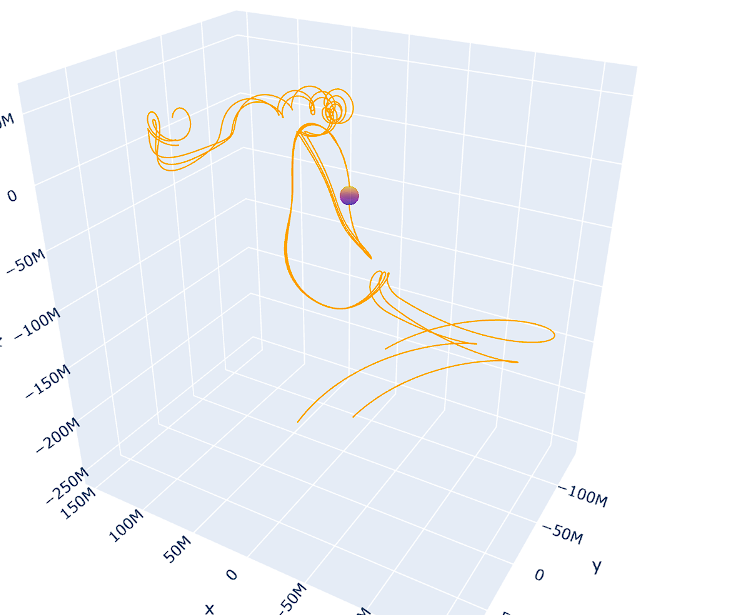
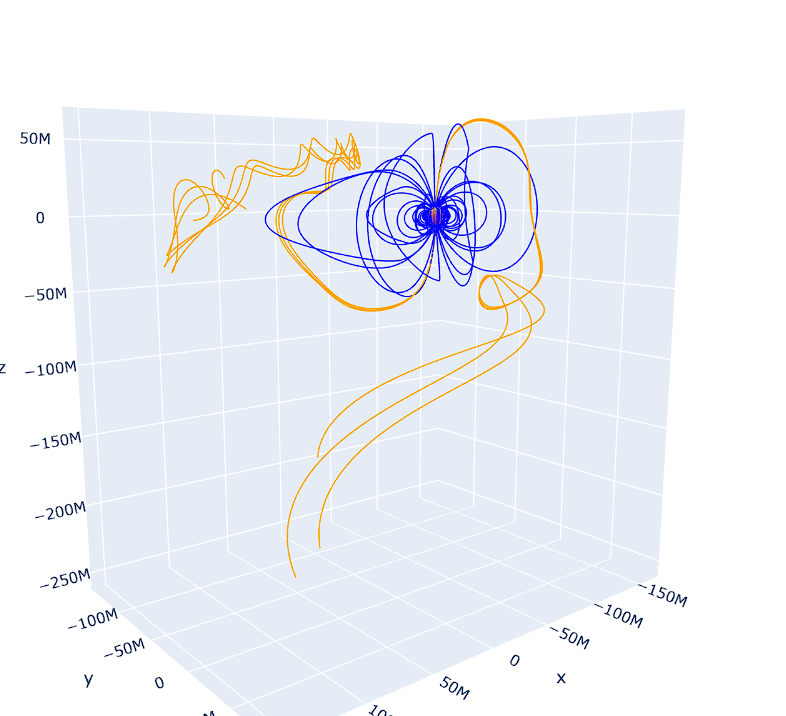